# Drainage extraction

In this notebook we will extract and plot some drainage areas. We will compare plotting using `lsdviztools` and `cartopy`. `cartopy` alongside `rasterio` is more felxible: there are general mapping tools. `lsdviztools` is a package built by the authors of *lsdtopotools* that is specifically for producing publication ready figure for specific studies. The documentation is much better for `cartopy` and `rasterio`. 

But first, we need to perform a drainage extraction from some test data. We are going to use a small lidar dataset. 

## Add some necessary packages

In [1]:
import lsdviztools.lsdmapwrappers as lsdmw
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio

### Get the example data

The example data is an 18 Mb topographic dataset which you need to download:

In [2]:
# Get the data from github
# an ftp or https call goes here

## Extract the drainage area using a variety of methods

The below call to *lsdtt-basic-metrics* asks for a d8, a d-infinity, and a multidirection flow accumulation rasters.

In [5]:
lsdtt_parameters = {"write_hillshade" : "true",
                    "print_d8_drainage_area_raster" : "true",
                    "print_dinf_drainage_area_raster" : "true",
                    "print_MD_drainage_area_raster" : "true"}
r_prefix = "Guadalupe_DEM"
w_prefix = "Guadalupe_DEM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool = "lsdtt-basic-metrics", 
                                 read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: Guadalupe_DEM
The write prefix is: Guadalupe_DEM
The parameter dictionary is:
{'write_hillshade': 'true', 'print_d8_drainage_area_raster': 'true', 'print_dinf_drainage_area_raster': 'true', 'print_MD_drainage_area_raster': 'true'}
Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.
|| Welcome to the LSDTopoTools basic metrics tool!     ||
|| This program has a number of options for calculating||
|| simple landscape metrics.                           ||
|| This program was developed by Simon M. Mudd         ||
||  at the University of Edinburgh                     ||
|| If you

We can look at the files we generated using an `ls` call to the underlying file system (we access the underlying system with the symbol `!`:

In [6]:
!ls

Guadalupe+DEM_ingestedParam.param  Guadalupe_DEM_hs.hdr
Guadalupe_DEM.bil		   Guadalupe_DEM_ingestedParam.param
Guadalupe_DEM.hdr		   Test_01.driver
Guadalupe_DEM_MD_area.bil	   channel_steepness_and_concavity.ipynb
Guadalupe_DEM_MD_area.hdr	   drainage_extraction_with_lsdtopotools.ipynb
Guadalupe_DEM_d8_area.bil	   lsdtopotools_on_colab.ipynb
Guadalupe_DEM_d8_area.hdr	   lsdtopotools_with_condacolab.ipynb
Guadalupe_DEM_dinf_area.bil	   starting_guide_to_lsdtopotools.ipynb
Guadalupe_DEM_dinf_area.hdr	   tour_of_lsdtt_basic_metrics.ipynb
Guadalupe_DEM_hs.bil


You should see several rasters with `_area` in the filename as well as an indicator of what method was used. Lets have a look at these data. 

## Plotting the data with imshow 

First we jut plot the draiange are with imshow and rasterio with no real adjustments to the plotting:

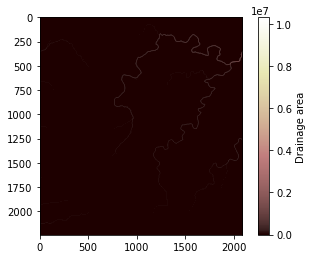

In [20]:
%matplotlib inline
import rasterio
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
src = rasterio.open('Guadalupe_DEM_d8_area.bil')
cs = ax.imshow(src.read(1), cmap='pink')

cbar = fig.colorbar(cs,label="Drainage area")

There are some rather glaring problems with this plot:
    
* You can't see anything on the plot (if you really squint you can see a single channel.
* The axes labels don't retain spatial information (imshow plots axes with pixel numbers and doesn't know anything about geography).

We will fix there problems one at a time.

### Fix the problem with not being able to see the channels

The problem with not being able to see the channels is becasue drainage area varies over several orders of magnitude. Whenever you have a dataset that varies over several orders of magnitude and you want to plot the data your best option is to use a logarithmic scale. So I will do that below:

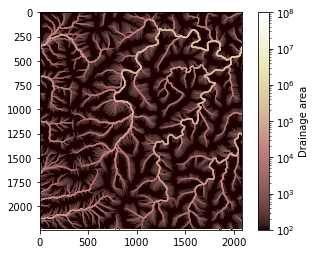

In [19]:
%matplotlib inline
import rasterio
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
src = rasterio.open('Guadalupe_DEM_d8_area.bil')
cs = ax.imshow(src.read(1), cmap='pink', norm=LogNorm(vmin=100, vmax=100000000))

cbar = fig.colorbar(cs,label="Drainage area")
#cbar.ax.minorticks_off()  # Uncomment this if the colourbar is too cluttered

That looks better! Now for the next problem: we need some spatial coordinates. 
To do this we need to get geospatial information from the raster. Rasterio is great for this purpose. 

### Getting geospatial information from your DEM using rasterio

In [24]:
import cartopy as cp
import cartopy.crs as ccrs

First we get the extent of the DEM. We need this for plotting later

In [28]:
bounds = src.bounds
Extent = [bounds.left,bounds.right,bounds.bottom,bounds.top]

Then we get the coordinate reference system (`crs`). 

*LSDTopoTools* uses the UTM coordinate system as a default. You need to use the UTM zone for plotting later. So you will need to just read the zone (the last two digits in the output from the next command) for the steps thereafter.

In [27]:
src.crs

CRS.from_epsg(32613)

Okay, so the last two digits are `13` so in the below code there are a number of instances of calls to `.UTM` and we need to put `13` in each of these calls. If you had a different dataset you would use that dataset's UTM zone. 

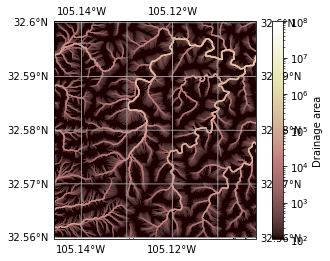

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
cs = ax.imshow(src.read(1), cmap='pink', norm=LogNorm(vmin=100, vmax=100000000),
               extent=Extent, transform=ccrs.UTM(13), origin="upper")
cbar = fig.colorbar(cs,label="Drainage area")
#fig.savefig("test.png", dpi=300)

Okay, now we have a plot with spatial coordinates! Thanks `cartopy`! The labels are a bit messed up but we'll try to correct that later. 
First we will try to make the image nicer by draping the drainage area over a hillshade. 

### Fixing a washed out hillshade 

Before we do the final part I need to show you a potential problem with the hillshade and using `imshow`. 
Let's plot the hillshade data using the same method as last time:

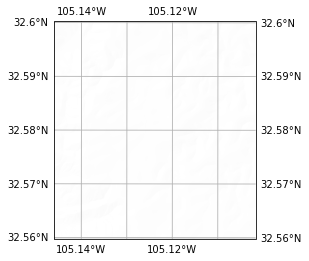

In [56]:
# First load the hillshade with rasterio
DEMHSdata = rasterio.open('Guadalupe_DEM_HS.bil')

# Now plot. We remove the code with the logarithmic scale for the hillshde image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
cs = ax.imshow(DEMHSdata.read(1), cmap='gray', 
               extent=Extent, transform=ccrs.UTM(13), origin="upper")

Hey, what gives? That doesn't look like a hillshade!!

The problem is that there is some nodata in this raster, and the nodata value is -9999. The hillshade data has values between 0 and 256 so these -9999 values wash out the colour scale. You can fix this in two ways. 

One is you can plot the colourbar only over a range, using the colour limits that are denoted using `vmin` and `vmax`. Like this:

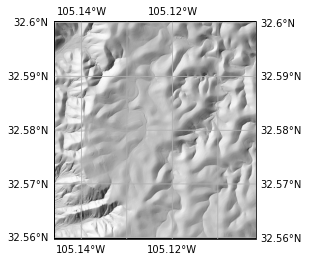

In [55]:
# Now plot. We remove the code with the logarithmic scale for the hillshde image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
cs = ax.imshow(DEMHSdata.read(1), cmap='gray', vmin=0, vmax=256,
               extent=Extent, transform=ccrs.UTM(13), origin="upper")

Alternatively you could load the data as an array and use `numpy` array manipulation tools to get rid of those -9999 values. 

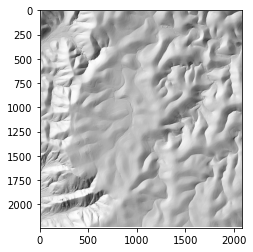

In [44]:
import numpy as np
DEMHSdata = rasterio.open('Guadalupe_DEM_HS.bil')
arrayHS = DEMHSdata.read(1)
arrayHS[arrayHS==-9999]=np.nan
plt.imshow(arrayHS,cmap="gray")

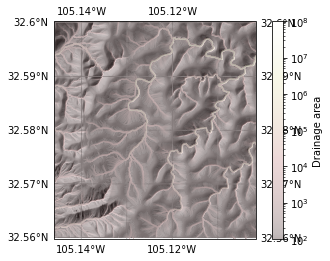

In [47]:
DEMHSdata = rasterio.open('Guadalupe_DEM_HS.bil')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax.imshow(arrayHS, cmap='gray',
              extent=Extent, transform=ccrs.UTM(13), origin="upper",
               alpha = 1)
cs = ax.imshow(src.read(1), cmap='pink', norm=LogNorm(vmin=100, vmax=100000000),
               extent=Extent, transform=ccrs.UTM(13), origin="upper",
               zorder=2,alpha=0.3)
cbar = fig.colorbar(cs,label="Drainage area")

## Okay, lets try the same thing with lsdviztools

In [78]:
### Plot the topographic gradient  
Base_file = "Guadalupe_DEM"
Drape_prefix = r_prefix+"_dinf_area"
DataDirectory = "./"
this_area_img = lsdmw.SimpleDrape(DataDirectory,Base_file,Drape_prefix, cmap="pink", 
                                       cbar_label = "Drainage area",
                                       cbar_loc = "bottom",
                                       drape_cnorm = "LogNorm",
                                       colour_min_max = [1000,10000000],
                                       save_fig=True, size_format="ESURF",dpi=600)

Your colourbar will be located: bottom
xsize: 2084 and y size: 2243
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32613
EPSG:32613
The EPSGString is: EPSG:32613
minimum values are x: 486286.0 and y: 3602493.0
I made the ticks.
x labels are: 
['487', '487', '488', '489', '490']
x locations are:
[487000.0, 487800.0, 488600.0, 489400.0, 490200.0]
y labels are: 
['3603', '3604', '3604', '3605', '3606']
y locations are:
[3603200.0, 3604000.0, 3604800.0, 3605600.0, 3606400.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
N axes are: 1
Axes(0,0;1x1)
xsize: 2084 and y size: 2243
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32613
EPSG:32613
The EPSGString is: EPSG:32613
I am going to use the normalisation LogNorm
I am using the full range of values in the raster.
custom min and max are:
1000
10000000
I am setting customisable colourbar minimum and maximum values: 1000,10000000
The number of axes are: 2
The aspect ratio is: 0.9291127953633527
I need to adjust the

<Figure size 432x288 with 0 Axes>

./Guadalupe_DEM_drape.png


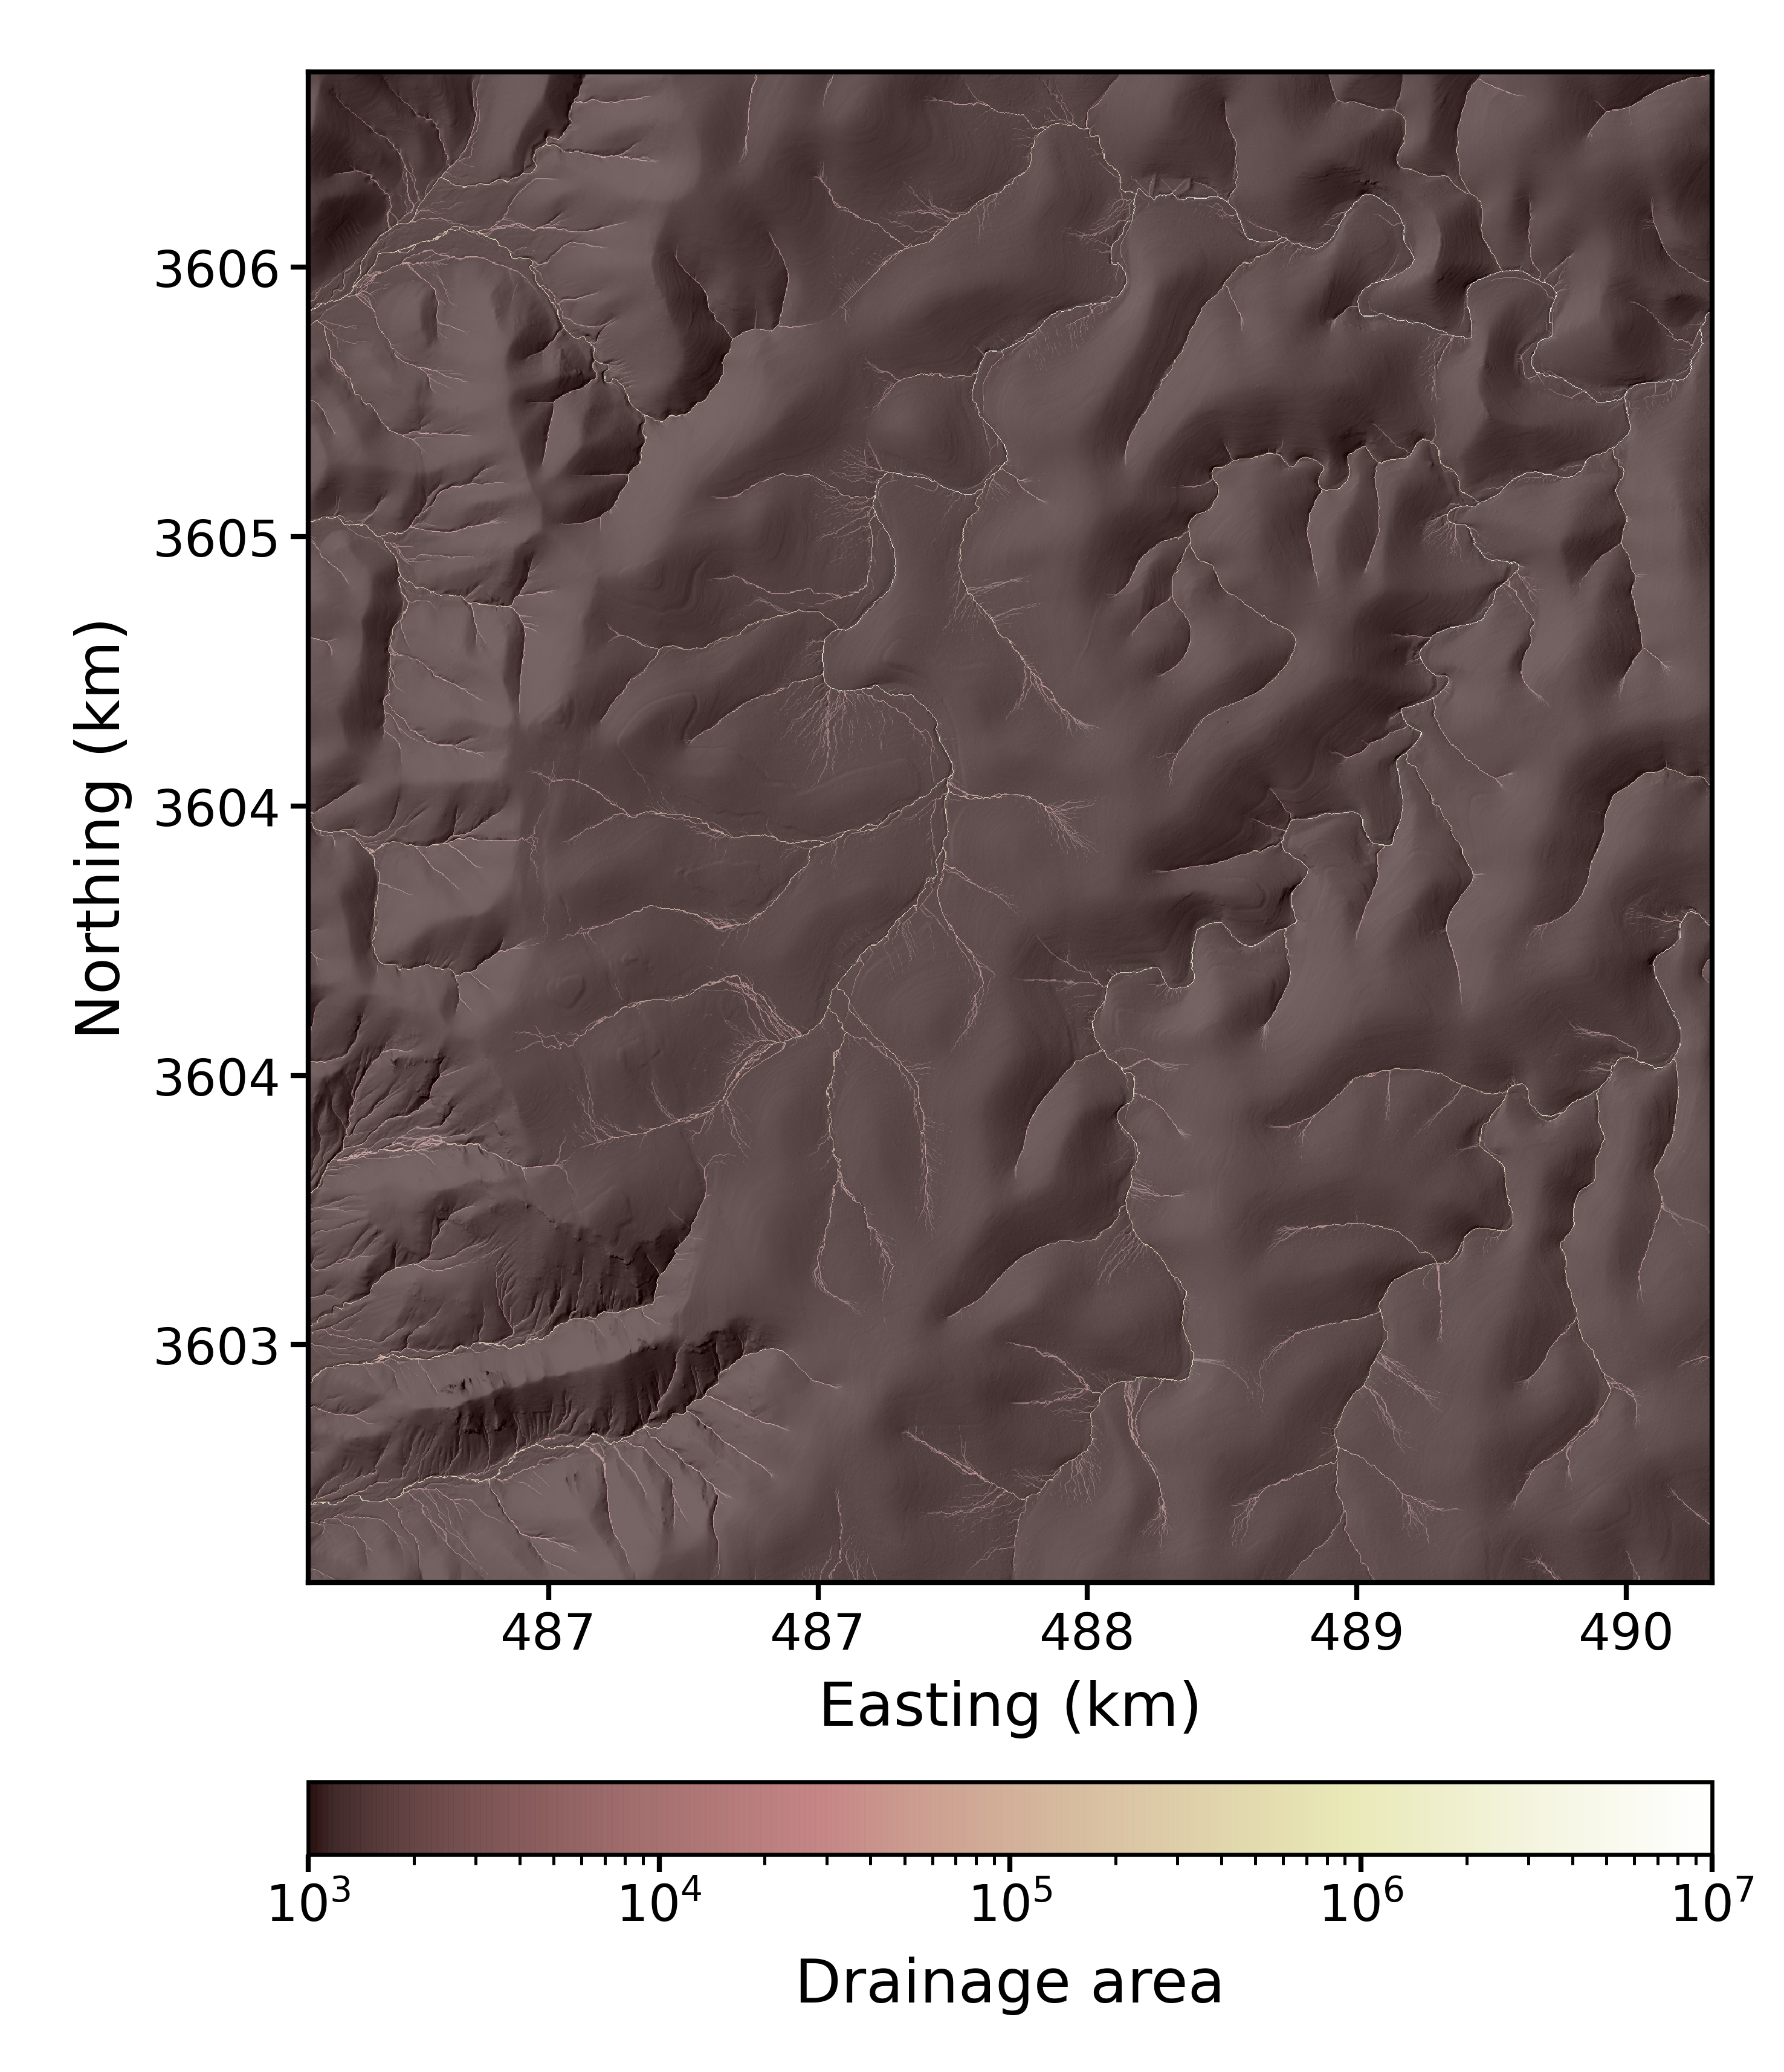

In [79]:
print(this_area_img)
from IPython.display import display, Image
display(Image(filename=this_area_img, width=600))